<a href="https://colab.research.google.com/github/KirillR2005/MentorFall2024/blob/main/MentorFall2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting up the framework

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import pandas as pd

In [ ]:
# Setting up the framework

RANDOM_SEED = 39
torch.manual_seed(seed=RANDOM_SEED)
torch.cuda.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Defining the main functions

In [ ]:
quantum_device = qml.device("default.qubit", wires=4)

def QFT(qubits):
    """Applies the Quantum Fourier Transform to a specified number of qubits."""
    n_qubits = len(qubits)

    for i in range(n_qubits):

        qml.Hadamard(wires=qubits[i])

        for j in range(i + 1, n_qubits):

            angle = np.pi / (2 ** (j - i))
            qml.ControlledPhaseShift(angle, wires=[qubits[j], qubits[i]])

    for i in range(n_qubits // 2):

        qml.SWAP(wires=[qubits[i], qubits[n_qubits - i - 1]])

def quantum_state(data):
  # Проверка, что длина массива равна 2^n
    N = len(data)
    if (N & (N - 1)) != 0:
        raise ValueError("Длина массива должна быть степенью двойки (2^n).")

    # Нормализация данных для создания амплитуд
    norm = np.linalg.norm(data)
    normalized_data = data / norm

    # Определение количества кубитов
    n_qubits = int(np.log2(N))

    # Определение квантового устройства с нужным числом кубитов
    dev = qml.device("default.qubit", wires=n_qubits)

    # Создание квантовой функции для инициализации состояния
    @qml.qnode(dev)
    def circuit():
        # Инициализация квантового состояния с амплитудами normalized_data
        qml.QubitStateVector(normalized_data, wires=range(n_qubits))
        return qml.state()  # Вернуть состояние для проверки

    # Запуск схемы и получение состояния
    quantum_state = circuit()

    return quantum_state

def inverse_QFT(qubits):
    """Applies the inverse Quantum Fourier Transform to a specified number of qubits."""
    n_qubits = len(qubits)

    for i in range(n_qubits // 2):

        qml.SWAP(wires=[qubits[i], qubits[n_qubits - i - 1]])

    for i in range(n_qubits - 1, -1, -1):

        qml.Hadamard(wires=qubits[i])

        for j in range(i):

            angle = -np.pi / (2 ** (i - j))
            qml.ControlledPhaseShift(angle, wires=[qubits[j], qubits[i]])

def DFT(Arr):
    result = torch.zeros(Arr.shape)
    for i in range(Arr.shape[0]):
      result[i] = torch.fft.fft(Arr[i])
    return result.to(device)

def IDFT(Arr):
    result = torch.zeros(Arr.shape)
    for i in range(Arr.shape[0]):
      result[i] = torch.fft.ifft(Arr[i])
    return result.to(device)

def quantum_conv_layer(inputs, params):
    # Применяем RY и CNOT, чтобы захватить локальные особенности
    for i in range(0, n_qubits - 1, 2):  # Через один кубит
        qml.RY(params[i], wires=i)
        qml.CNOT(wires=[i, i + 1])

    # Применяем дополнительные гейты к оставшимся кубитам
    for i in range(1, n_qubits, 2):
        qml.RY(params[i], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

#weight_shapes = {"weights": (4,)}
#qconv_layer = qml.qnn.TorchLayer(quantum_conv_layer, weight_shapes)

# example of using
n_qubits = 3
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev)
def qft_circuit():
    # Example input state (|000⟩, but you can customize it)
    qml.BasisState(np.array([1, 0, 0]), wires=range(n_qubits))  # Set state |100⟩ as an example

    # Apply Quantum Fourier Transform
    QFT(range(n_qubits))

    # Measure the final state

    return qml.state()

@qml.qnode(dev)
def qnode_1(inputs, weights):
    result = []
    for i in range(len(inputs)//len(inputs[0])):
      qml.AmplitudeEmbedding(inputs[i], wires=range(n_qubits), pad_with=0.0, normalize=True)
      QFT(range(n_qubits))
      result.append([qml.expval(qml.PauliZ(wires = j)) for j in range(n_qubits)])
    return result

qft_result = qft_circuit()
print("QFT result (amplitudes):\n", qft_result)
print("\nQFT result (probabilities):\n", np.abs(qft_result) ** 2)

QFT result (amplitudes):
 [ 0.35355339+0.j -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j
  0.35355339+0.j -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j]

QFT result (probabilities):
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [ ]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def circuit():
  qml.StatePrep(np.random.rand(2**n_qubits), wires = [0, 1, 2, 3], normalize=True)
  #quantum_conv_layer([np.pi/2, np.pi/3, np.pi/4])
  QFT(range(n_qubits))
  return qml.state()

print((circuit()).round(4))
#print((np.abs(circuit())**2).round(4))


[ 0.8857+0.j      0.0666+0.0364j -0.0051-0.0639j  0.0233+0.0138j
 -0.1005-0.1386j  0.0123-0.1253j  0.0414+0.0903j  0.1933+0.0035j
  0.0976+0.j      0.1933-0.0035j  0.0414-0.0903j  0.0123+0.1253j
 -0.1005+0.1386j  0.0233-0.0138j -0.0051+0.0639j  0.0666-0.0364j]


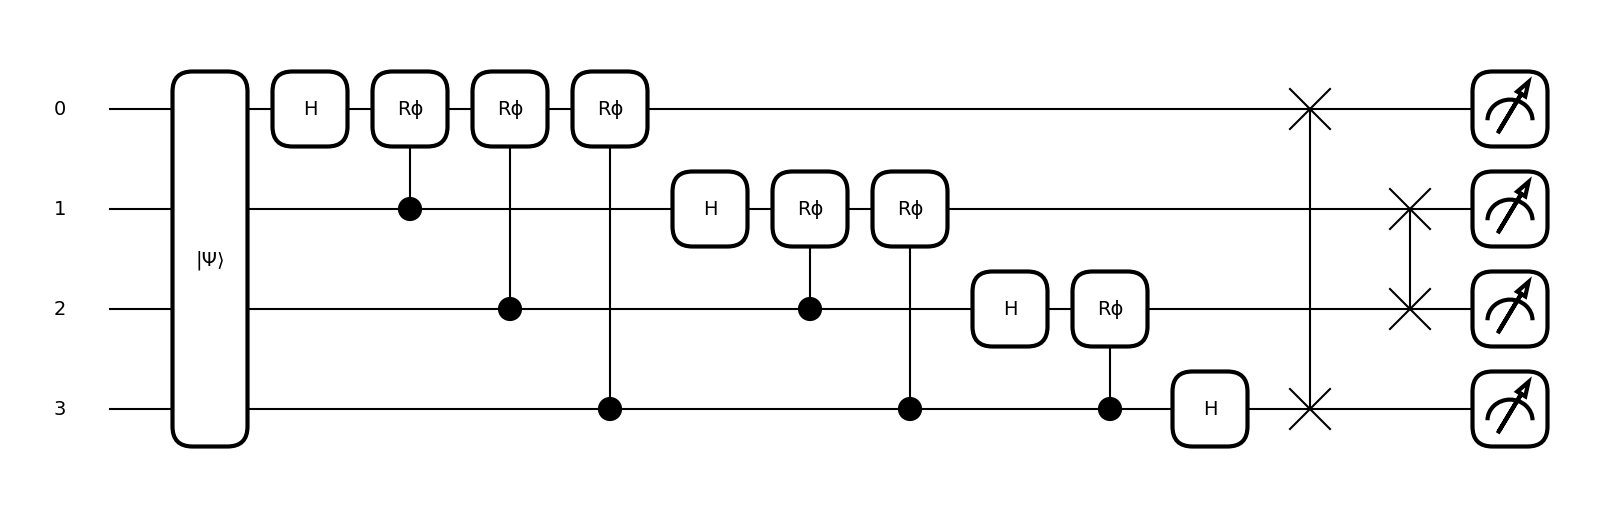

In [ ]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit)()
#plt.show()
plt.savefig("QFTcircuit.svg")

In [ ]:
q_data = quantum_state([1, 0, 0, 1, 0, 0, 1, 0])
q_data.real.round(4)

/usr/local/lib/python3.10/dist-packages/pennylane/ops/qubit/state_preparation.py:453: PennyLaneDeprecationWarning: QubitStateVector is deprecated and will be removed in version 0.40. Instead, please use StatePrep.
  warnings.warn(


array([0.5774, 0.    , 0.    , 0.5774, 0.    , 0.    , 0.5774, 0.    ])

In [ ]:
import tensorflow_datasets as tfds
from torch.utils.data import Dataset, DataLoader

### Installing the dataset

In [ ]:
class STOCKSDataset(Dataset):
    def __init__(self, data_x, data_y, n):
        self.X = torch.tensor(data_x).reshape(-1, n, 128)
        self.y = torch.tensor(data_y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
# Import all data from Google Drive

from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive if you haven't already

!unzip /content/drive/MyDrive/Market_data.zip

#read all files

import os

path = "/content/stocks"  # Add the leading '/' to specify the path from root
dir_list = os.listdir(path)
dir_list.sort()

S = 0
a = 0
for i in range(len(dir_list)):
    name = "/content/stocks/" + dir_list[i]
    try:
        file = np.array(pd.read_csv(name))
        S += file.size
        a += 1
    except:
        print(name)
S = S//7
print(S)
print(len(dir_list))
print(a)

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: __MACOSX/stocks/._PEAK.csv  
  inflating: stocks/IAC.csv          
  inflating: __MACOSX/stocks/._IAC.csv  
  inflating: stocks/ETO.csv          
  inflating: __MACOSX/stocks/._ETO.csv  
  inflating: stocks/ISBC.csv         
  inflating: __MACOSX/stocks/._ISBC.csv  
  inflating: stocks/GTES.csv         
  inflating: __MACOSX/stocks/._GTES.csv  
  inflating: stocks/WIL.csv          
  inflating: __MACOSX/stocks/._WIL.csv  
  inflating: stocks/BSM.csv          
  inflating: __MACOSX/stocks/._BSM.csv  
  inflating: stocks/KIRK.csv         
  inflating: __MACOSX/stocks/._KIRK.csv  
  inflating: stocks/CAAP.csv         
  inflating: __MACOSX/stocks/._CAAP.csv  
  inflating: stocks/DHIL.csv         
  inflating: __MACOSX/stocks/._DHIL.csv  
  inflating: stocks/GMO.csv          
  inflating: __MACOSX/stocks/._GMO.csv  
  inflating: stocks/GNT.csv          
  inflating: __MACOSX/stocks/._GNT.csv  
  inflating: sto

In [ ]:
#total number of training examples
print(S//128 + 1)

file.shape

189043


(4054, 7)

In [ ]:
#creating the train dataset

X = torch.zeros(S//128 + 1, 5, 128)
V = torch.zeros(S//128 + 1, 1, 128)
W = torch.zeros(S//128 + 1, 2, 128)


y = torch.zeros(S//128 + 1)
y_diff = torch.zeros(S//128 + 1)
y_sign = torch.zeros(S//128 + 1, 3) #distribution of probabilities for (1, 0, -1) respectively

stride = 128
a = 0

In [ ]:
print(pd.read_csv(name))

            Date   Open   High    Low  Close  Adj Close  Volume
0     2004-02-25   2.90   2.90   2.81   2.82   1.534255   12800
1     2004-02-26   2.85   2.90   2.82   2.89   1.572340   59500
2     2004-02-27   2.89   2.95   2.85   2.90   1.577780   16300
3     2004-03-01   2.95   2.95   2.85   2.89   1.572340   14500
4     2004-03-02   2.95   3.02   2.80   2.85   1.550577   28700
...          ...    ...    ...    ...    ...        ...     ...
4049  2020-03-26  10.23  11.43  10.23  11.10  11.100000  189500
4050  2020-03-27  10.70  10.98  10.06  10.30  10.300000  145000
4051  2020-03-30  10.16  11.06  10.16  10.80  10.800000  162300
4052  2020-03-31  10.68  11.14  10.59  11.07  11.070000  280400
4053  2020-04-01  11.16  11.16  10.51  10.92  10.920000  315900

[4054 rows x 7 columns]


In [ ]:
#function returns weekdays
from datetime import datetime

dates = np.array(["2024-11-14", "2024-11-15", "2024-11-16"])
def get_weekdays(dates):
    if isinstance(dates, np.ndarray):
        dates = dates.astype(str).tolist()
    weekdays = [datetime.strptime(date, "%Y-%m-%d").weekday() for date in dates]
    return np.array(weekdays)


In [ ]:
#setting the prediction goals
a = 0
for i in range(len(dir_list)):
    name = "/content/stocks/" + dir_list[i]

    file = np.array(pd.read_csv(name))

    volume = torch.tensor(np.float32(file[:, 6]))
    weekdays = get_weekdays(file[:, 0])
    weekdays = torch.tensor(np.float32(weekdays))

    file = torch.tensor(np.float32(file[:, 1:6]))
    Lenght = file.size(0)
    for j in range(0, Lenght//stride - 2):
      X[a] = (file[stride*j : stride*j + 128, :]).T
      V[a] = volume[stride*j : stride*j + 128].unsqueeze(0)
      W[a, 0] = torch.sin(weekdays[stride*j : stride*j + 128]*2*np.pi/7)
      W[a, 1] = torch.cos(weekdays[stride*j : stride*j + 128]*2*np.pi/7)

      y[a] = file[stride*j + 148, 4]
      y_diff[a] = (file[stride*j + 148, 4] - file[stride*j + 127, 4]) #adj close price 20 workdays later

      if y_diff[a] > 0:
        y_sign[a] = torch.tensor([0.99, 0.005, 0.005])
      elif y_diff[a] < 0:
        y_sign[a] = torch.tensor([0.005, 0.005, 0.99])
      else:
        y_sign[a] = torch.tensor([0.005, 0.99, 0.005])
      a += 1
    if (i%200 == 0):
      print(i)
print(pd.read_csv(name))

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
            Date   Open   High    Low  Close  Adj Close  Volume
0     2004-02-25   2.90   2.90   2.81   2.82   1.534255   12800
1     2004-02-26   2.85   2.90   2.82   2.89   1.572340   59500
2     2004-02-27   2.89   2.95   2.85   2.90   1.577780   16300
3     2004-03-01   2.95   2.95   2.85   2.89   1.572340   14500
4     2004-03-02   2.95   3.02   2.80   2.85   1.550577   28700
...          ...    ...    ...    ...    ...        ...     ...
4049  2020-03-26  10.23  11.43  10.23  11.10  11.100000  189500
4050  2020-03-27  10.70  10.98  10.06  10.30  10.300000  145000
4051  2020-03-30  10.16  11.06  10.16  10.80  10.800000  162300
4052  2020-03-31  10.68  11.14  10.59  11.07  11.070000  280400
4053  2020-04-01  11.16  11.16  10.51  10.92  10.920000  315900

[4054 rows x 7 columns]


In [ ]:
# Checking for any values being nan

nan_values = ([])

mask = ~(torch.isnan(y) + torch.isnan(X).any(dim=(1,2)) + torch.isnan(V).any(dim=(1,2)) + torch.isnan(W).any(dim=(1,2)))

y = y[mask]
y_diff = y_diff[mask]
y_sign = y_sign[mask]
X = X[mask]
V = V[mask]
W = W[mask]

for i in range(y.size(0)):
  if y[i].isnan() or X[i].sum().isnan() or V[i].sum().isnan() or W[i].sum().isnan():
    y[i] = 0
    y_diff[i] = 0
    y_sign[i] = 0
    X[i] = torch.zeros(5, 128)
    V[i] = 0
    W[i] = torch.zeros(2, 128)

    nan_values.append(i)

print("nan_values:", nan_values)

for i in range(y.size(0)):
  if y[i].isnan() or X[i].sum().isnan():
    raise Exception("nan values")

nan_values: []


In [ ]:
X[X.max(dim = 2).values > 1e6].shape
y.std()

tensor(1.0894e+19)

In [ ]:
for i in range(X.size(0)):
  if (X[i].min().detach() < 0 or X[i].max().detach() > 1e6 or y[i] < 0 or y[i] > 1e6):
    X[i] = torch.zeros(5, 128)
    y[i] = 0
    y_diff[i] = 0
    y_sign[i] = torch.tensor([1/3, 1/3, 1/3])
    V[i] = 0
    W[i] = torch.zeros(2, 128)


In [ ]:
for i in range(X.size(0)):
  if y_sign[i].sum() == 0:
    y_sign[i] = torch.tensor([1/3, 1/3, 1/3])

In [ ]:
y_sign

tensor([[0.9900, 0.0050, 0.0050],
        [0.9900, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.9900],
        ...,
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])

In [ ]:
mask = ~(torch.sum(X, dim = (1, 2)) == 0)
mask.size(0) - X.size(0)

0

In [ ]:
y = y[mask]
y_diff = y_diff[mask]
y_sign = y_sign[mask]
X = X[mask]
V = V[mask]
W = W[mask]

In [ ]:
X.max(), X.min(), y.max(), y.min(), y_diff.max(), y_diff.min(), y_sign.max(), y_sign.min(), V.max(), V.min(), W.max(), W.min()

(tensor(980910.),
 tensor(0.),
 tensor(779250.),
 tensor(2.8582e-09),
 tensor(517140.),
 tensor(-168375.),
 tensor(0.9900),
 tensor(0.0050),
 tensor(1.8000e+10),
 tensor(0.),
 tensor(1.),
 tensor(-0.9010))

In [ ]:
mask = ~(torch.isnan(y_diff))

y = y[mask]
y_diff = y_diff[mask]
y_sign = y_sign[mask]
X = X[mask]
V = V[mask]
W = W[mask]

In [ ]:
V.size(), W.size(), X.size(), y.size(), y_diff.size(), y_sign.size()

(torch.Size([174189, 1, 128]),
 torch.Size([174189, 2, 128]),
 torch.Size([174189, 5, 128]),
 torch.Size([174189]),
 torch.Size([174189]),
 torch.Size([174189, 3]))

In [ ]:
for i in range(X.size(0)):
  V[i] += 1e-4
  X[i] += 1e-4
  y[i] += 1e-4
  X[i] = torch.log(X[i])
  V[i] = torch.log(V[i])
  y[i] = torch.log(y[i])
  min, max, mean, std = X[i].min().detach(), X[i].max().detach(), X[i].mean().detach(), (X[i].std().detach() + 1e-4)
  V_min, V_max, V_mean, V_std = V[i].min().detach(), V[i].max().detach(), V[i].mean().detach(), (V[i].std().detach() + 1e-4)

  X[i] = (X[i] - mean)/(std + 10e-5)
  V[i] = (V[i] - V_mean)/(V_std + 10e-5)
  y[i] = (y[i] - mean)/(std + 10e-5)
  y_diff[i] = y[i] - X[i, 3, 127]

In [ ]:
X.mean(), X.std(), y.mean(), y.std(), V.mean(), V.std()

(tensor(6.8096e-07),
 tensor(0.9972),
 tensor(-0.2799),
 tensor(182.1548),
 tensor(2.5938e-05),
 tensor(0.9931))

(0.0, 100000.0)

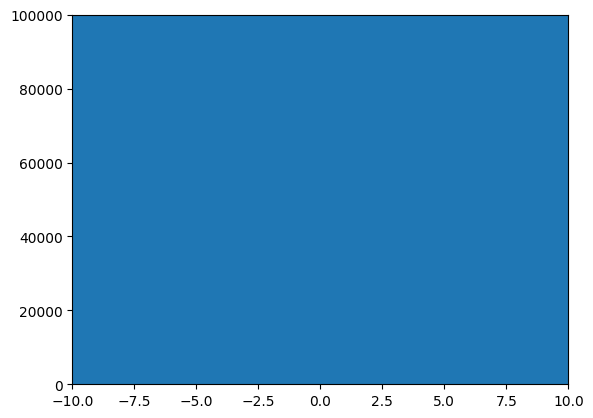

In [ ]:
plt.hist(y, bins = 100)
plt.xlim(-10, 10)
plt.ylim(0, 100000)

In [ ]:
X.size(0), y.size(0), y_diff.size(0), y_sign.size(0), V.size(0), W.size(0)

(174189, 174189, 174189, 174189, 174189, 174189)

In [ ]:
for i in range(y.size(0)):
  if y[i].isnan() or X[i].sum().isnan():
    raise Exception("nan values")

In [ ]:
# Checking for unexpectedly large values

for i in range(y.size(0)):
  if y[i]>100:
    y[i] = 0
    print(i)

for i in range(y_diff.size(0)):
  if (y_diff[i] > 10 or y_diff[i] < -10) :
    y_diff[i] = 0
    X[i] = 0
    y[i] = 0
    print(i)

19180
22607
33292
46642
54095
89886
92135
109678
134769
137740
158082
1311
1668
4406
4820
6211
7926
7987
9925
10492
12100
12532
14132
18065
19180
19830
21301
22607
23558
24005
27351
27744
30245
30943
33171
33292
35584
35591
39366
41651
42659
43308
45654
46642
46658
48212
49019
50503
51282
51893
54095
56180
62727
63891
63894
65565
66767
69249
74705
78817
80176
85135
85352
85427
85493
88300
89387
89797
89886
91022
91125
92133
92135
92138
93883
96496
101297
104647
106394
106431
109447
109617
109678
109740
113310
115862
117022
117938
118362
119362
121877
125244
125795
131331
131753
132496
133021
133410
134447
134769
135759
137101
137740
139872
141071
145408
145409
155341
155538
156140
158082
161516
161897
163627
165773
166316
167037
167181
168345
168625
170844
171428
173111
173127


In [ ]:
mask = ~(y == 0)

y = y[mask]
y_diff = y_diff[mask]
y_sign = y_sign[mask]
X = X[mask]
V = V[mask]
W = W[mask]

X.size(0), y.size(0), y_diff.size(0), y_sign.size(0), V.size(0), W.size(0)

(174011, 174011, 174011, 174011, 174011, 174011)

(0.0, 100000.0)

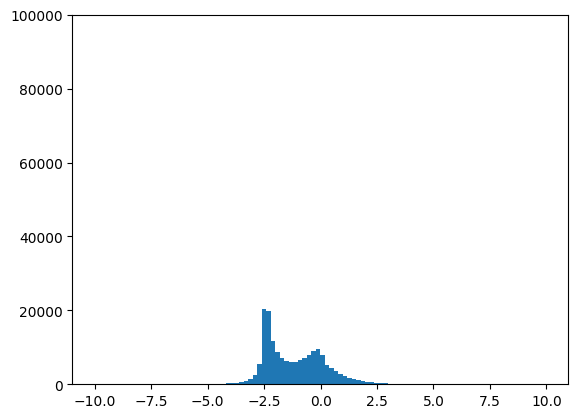

In [ ]:
plt.hist(y_diff, bins = 100)
plt.xlim()
plt.ylim(0, 100000)

In [ ]:
W.size()

torch.Size([174011, 2, 128])

In [ ]:
X = torch.cat((X, V, W), 1)
X.size()

torch.Size([174011, 8, 128])

In [ ]:
y_sign = y_sign*0.8 + 0.2/3
y_sign

tensor([[0.8587, 0.0707, 0.0707],
        [0.8587, 0.0707, 0.0707],
        [0.0707, 0.0707, 0.8587],
        ...,
        [0.0707, 0.0707, 0.8587],
        [0.8587, 0.0707, 0.0707],
        [0.0707, 0.0707, 0.8587]])

In [ ]:
# Splitting into train and test

X_train, X_test = X[0:4*X.size(0)//5], X[4*X.size(0)//5:]
y_train, y_test = y[0:4*X.size(0)//5], y[4*X.size(0)//5:]
y_diff_train, y_diff_test = y_diff[0:4*X.size(0)//5], y_diff[4*X.size(0)//5:]
y_sign_train, y_sign_test = y_sign[0:4*X.size(0)//5], y_sign[4*X.size(0)//5:]

In [ ]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
y_diff_train = y_diff_train.to(device)
y_diff_test = y_diff_test.to(device)
y_sign_train = y_sign_train.to(device)
y_sign_test = y_sign_test.to(device)

In [ ]:
#Datasets themselves

train_dataset_val = STOCKSDataset(X_train, y_train, 8)
train_dataset_diff = STOCKSDataset(X_train, y_diff_train, 8)
train_dataset_sign = STOCKSDataset(X_train, y_sign_train, 8)

test_dataset_val = STOCKSDataset(X_test, y_test, 8)
test_dataset_diff = STOCKSDataset(X_test, y_diff_test, 8)
test_dataset_sign = STOCKSDataset(X_test, y_sign_test, 8)

<ipython-input-10-c37864b16c2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(data_x).reshape(-1, n, 128)
<ipython-input-10-c37864b16c2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(data_y)


In [ ]:
batch_size = 512 #can be altered

train_dataloader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=True, drop_last=True )
test_dataloader_val = DataLoader(test_dataset_val, batch_size=batch_size, shuffle=False)

train_dataloader_diff = DataLoader(train_dataset_diff, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader_diff = DataLoader(test_dataset_diff, batch_size=batch_size, shuffle=False)

train_dataloader_sign = DataLoader(train_dataset_sign, batch_size=batch_size, shuffle=True, drop_last=True )
test_dataloader_sign = DataLoader(test_dataset_sign, batch_size=batch_size, shuffle=False)

for batch in train_dataloader_val:
    print(batch)
    break

print("lenght of test_dataloader_val:", len(test_dataloader_val))
print("size of a batch:", batch[0].shape, ",", batch[1].shape)

[tensor([[[ 8.0103e-02,  6.4430e-01,  6.2722e-01,  ..., -2.0395e+00,
          -2.5199e+00, -3.3767e+00],
         [ 7.7131e-01,  7.1227e-01,  6.8685e-01,  ..., -1.9120e+00,
          -2.3972e+00, -3.3494e+00],
         [ 6.1858e-02,  4.2832e-01,  5.0670e-01,  ..., -3.3903e+00,
          -3.4728e+00, -5.0950e+00],
         ...,
         [ 3.1054e-01,  4.8311e-01,  8.3467e-01,  ...,  2.6016e+00,
           2.1144e+00,  3.9243e+00],
         [ 9.7493e-01,  4.3388e-01, -4.3388e-01,  ...,  0.0000e+00,
           7.8183e-01,  9.7493e-01],
         [-2.2252e-01, -9.0097e-01, -9.0097e-01,  ...,  1.0000e+00,
           6.2349e-01, -2.2252e-01]],

        [[ 1.6156e+00,  9.7900e-01,  9.7900e-01,  ..., -5.7581e-01,
          -5.7581e-01, -5.7581e-01],
         [ 1.6156e+00,  9.7900e-01,  1.6156e+00,  ..., -5.7581e-01,
           2.5731e-01, -5.7581e-01],
         [ 9.7900e-01,  9.7900e-01,  9.7900e-01,  ..., -5.7581e-01,
          -5.7581e-01, -5.7581e-01],
         ...,
         [ 4.2643e-01, -

### Analyzing the dataset

tensor([[ 18.5836,  14.7715, -12.0469, -10.7364,  17.7919, -12.1773,  -0.3687,
           1.0484,   0.0342,  -7.2077,   5.2555,   1.6289,   1.9397,   0.0523,
           1.7409,  -3.2963,   1.0719,   1.7148,   1.3737,   2.3572,   2.4067,
          -3.6364,  -2.1564,   1.6996,   2.0188,   1.7311,   0.4187,   0.6616,
          -2.1419,   3.9100,   2.8863,   2.5653,   0.2745,   0.6230,  -0.6095,
           0.7676,  -1.4254,  -0.2614,   0.6566,   0.5045,  -0.2136,   0.4227,
           2.5104,   0.6014,   2.0452,   0.4708,   0.9135,  -1.4202,   2.9590,
           3.1763,   1.6262,   0.6265,   0.8341,  -0.2337,   1.6009,   0.7031,
          -1.5694,   0.3823,   0.3604,   0.1386,   0.4696,   2.6235,  -0.7201,
           0.5536,  -0.4787,   0.5536,  -0.7201,   2.6235,   0.4696,   0.1386,
           0.3604,   0.3823,  -1.5694,   0.7031,   1.6009,  -0.2337,   0.8341,
           0.6265,   1.6262,   3.1763,   2.9590,  -1.4202,   0.9135,   0.4708,
           2.0452,   0.6014,   2.5104,   0.4227,  -0

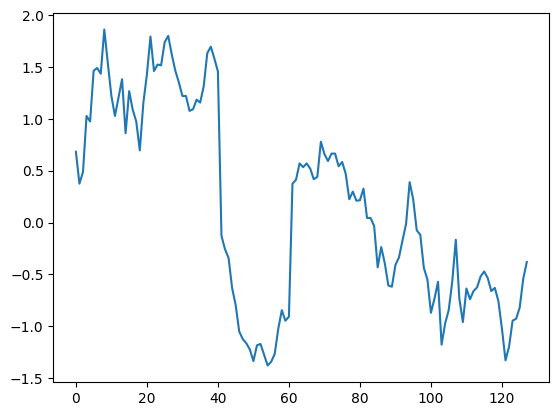

In [ ]:
plt.plot(X[1, 0, :])
DFT(X[1, 0, :].unsqueeze(0)).real

In [ ]:
dev = qml.device("default.qubit", wires=7)
@qml.qnode(dev)
def circuit():
  qml.QubitStateVector(X[1,:, 0], wires = [0, 1, 2, 3, 4, 5, 6], normalize=True)
  QFT(range(7))
  #inverse_QFT(range(7))

  return qml.state()

plt.plot((circuit()).real.round(4)), plt.plot(circuit().imag.round(4))
#plt.plot((np.abs(circuit())**2).round(4), 'bo', markersize = 3)

/usr/local/lib/python3.10/dist-packages/pennylane/ops/qubit/state_preparation.py:453: PennyLaneDeprecationWarning: QubitStateVector is deprecated and will be removed in version 0.40. Instead, please use StatePrep.
  warnings.warn(


ValueError: State must be of length 128; got length 8. Use the 'pad_with' argument for automated padding.

In [ ]:
# Analyzing Fourier coefficient

Adapted = np.concatenate(( circuit().real.round(4)[64:], circuit().real.round(4)[:64]))


coef = np.zeros(128)
for i in range(128):
  coef[i] = np.abs(i - 64 + 0.5)
Adapted *= coef
plt.plot(Adapted)

In [ ]:
plt.subplot(111)
plt.plot((np.abs(circuit())**2).round(4)[0:20], 'ro', markersize = 3)
plt.plot((np.abs(circuit())**2).round(4)[109:], 'bo', markersize = 3)

In [ ]:
plt.plot(X[1,:, 0])

In [ ]:
diff = X[1:100, 1:, 0] - X[1:100, :-1, 0]

In [ ]:
plt.hist(diff.detach().flatten(), bins = 100)
plt.xlim(-1.5, 1.5)


###Model and Training


In [ ]:
class MS2_probe_classical(nn.Module):
  def __init__ (self):
    super().__init__()
    self.convlayer1 = nn.Conv1d(in_channels = 5, out_channels = 8, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer3 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer4 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)

    self.q_convlayer1 = nn.Conv1d(in_channels = 5, out_channels = 5, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer2 = nn.Conv1d(in_channels = 13, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer3 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer4 = nn.Conv1d(in_channels = 64, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)

    #self.DFTlayer = torch.fft.fft()

    self.poollayer = nn.MaxPool1d(kernel_size = (2), stride = 2)

    self.batchnorm1 = nn.BatchNorm1d(num_features = 8)
    self.batchnorm2 = nn.BatchNorm1d(num_features = 16)
    self.batchnorm3 = nn.BatchNorm1d(num_features = 32)
    self.batchnorm4 = nn.BatchNorm1d(num_features = 32)

    self.q_batchnorm1 = nn.BatchNorm1d(num_features = 5)
    self.q_batchnorm2 = nn.BatchNorm1d(num_features = 16)
    self.q_batchnorm3 = nn.BatchNorm1d(num_features = 32)
    self.q_batchnorm4 = nn.BatchNorm1d(num_features = 32)

    self.flatten = nn.Flatten()
    self.fclayer = nn.Linear(1024, 1)

  def forward(self, x):
    #x = x.permute(0, 2, 1) #needs to be fixed
    k_1 = torch.fft.fft(x).real
    k_1.requires_grad=True
    x = self.convlayer1(x)
    x = F.leaky_relu(x)
    x = self.batchnorm1(x)
    k_2 = torch.fft.fft(x).real
    k_2.requires_grad=True
    x = self.poollayer(x)
    x = self.convlayer2(x)
    x = F.leaky_relu(x)
    x = self.batchnorm2(x)
    k_3 = torch.fft.fft(x).real
    k_3.requires_grad=True
    x = self.poollayer(x)
    x = self.convlayer3(x)
    x = F.leaky_relu(x)
    x = self.batchnorm3(x)
    k_4 = torch.fft.fft(x).real
    k_4.requires_grad=True
    x = self.poollayer(x)
    x = self.convlayer4(x)
    x = F.leaky_relu(x)
    x = self.batchnorm4(x)

    x = self.flatten(x)

    k_1 = F.leaky_relu(self.q_convlayer1(k_1))
    k_1 = self.q_batchnorm1(k_1)
    #print("Shape of k_1:", k_1.shape)
    #print("Shape of k_2:", k_2.shape)
    k_1 = torch.cat((k_1, k_2), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer2(k_1))
    k_1 = self.q_batchnorm2(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_3), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer3(k_1))
    k_1 = self.q_batchnorm3(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_4), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer4(k_1))
    k_1 = self.q_batchnorm4(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = self.flatten(k_1)


    #print("Shape of k_1:", k_1.shape)
    #print("Shape of x:", x.shape)
    x = torch.concat((x, k_1), (x.dim() - 1))

    x = self.fclayer(x)
    return x

In [ ]:
Tensor_1 = torch.tensor([ 0.5699,  0.2503,  0.3674,  0.9285,  0.8728,  1.3821,  1.4090,  1.3512,
         1.7947,  1.4548,  1.1285,  0.9285,  1.1121,  1.2965,  0.7549,  1.1771,
         0.9919,  0.8728,  0.5837,  1.0586,  1.3434,  1.7237,  1.3783,  1.4434,
         1.4358,  1.6661,  1.7309,  1.5450,  1.3821,  1.2650,  1.1285,  1.1285,
         0.9793,  0.9961,  1.0916,  1.0628,  1.2252,  1.5561,  1.6224,  1.5039,
         1.3744, -0.2726, -0.4075, -0.4939, -0.7943, -0.9652, -1.2306, -1.3064,
        -1.3483, -1.4119, -1.5271, -1.3694, -1.3553, -1.4619, -1.5710, -1.5344,
        -1.4547, -1.2034, -1.0170, -1.1226, -1.0827,  0.2503,  0.2897,  0.4532,
         0.4153,  0.4532,  0.4009,  0.2946,  0.3189,  0.6701,  0.5468,  0.4768,
         0.5514,  0.5514,  0.4248,  0.4674,  0.3481,  0.0945,  0.1706,  0.0792,
         0.0843,  0.2006, -0.0933, -0.0933, -0.1739, -0.5879, -0.3847, -0.5465,
        -0.7696, -0.7819, -0.5642, -0.4881, -0.3171, -0.1523,  0.2651,  0.0945,
        -0.2175, -0.2615, -0.5938, -0.7082, -1.0432, -0.9012, -0.7326, -1.3624,
        -1.1494, -1.0170, -0.7326, -0.3115, -0.9012, -1.1360, -0.8005, -0.9075,
        -0.8255, -0.7881, -0.6778, -0.6296, -0.6960, -0.8255, -0.7943, -0.9267,
        -1.2034, -1.5198, -1.3835, -1.1226, -1.1026, -0.9910, -0.7021, -0.5348])

probe_input = torch.zeros(5, 128)
for i in range(5):
  probe_input[i] = Tensor_1

In [ ]:
probe_model = MS2_probe_classical()
probe_model.to(device)

In [ ]:
model_total_params = sum(p.numel() for p in probe_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')


In [ ]:
#optimizer, loss
optimizer = optimizer = torch.optim.Adam(probe_model.parameters(), betas = (0.9, 0.99), lr = 0.001)
loss_function = nn.MSELoss()

In [ ]:
  #needs to be checked

def train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        model.train()
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device) #can be y_diff or y_sign

            # model forward-pass
            prediction = model(X)

            # model backward-pass
            optimizer.zero_grad()
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            train_accuracy += (np.sign(prediction.detach().cpu()) == np.sign(y.detach().cpu())).cpu().numpy().mean()

        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            with torch.no_grad():
                # model forward-pass
                prediction = model(X)
                loss = criterion(prediction, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (np.sign(prediction.detach().cpu()) == np.sign(y.detach().cpu())).cpu().numpy().mean()

        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

def eval(model, criterion, test_dataloader):
    test_losses = np.array([])
    test_loss = 0

    for batch in test_dataloader:
        X = batch[0].to(device)
        y = batch[1].to(device)

        with torch.no_grad():

            prediction = model(X)
            loss = criterion(prediction, y)
            test_loss += loss.detach().cpu().numpy()
            np.append(test_losses, np.array(loss))

    test_loss /= len(test_dataloader)

    plt.hist(test_losses, bins = 20)

def show_logs(logs, show_accuracy = True):
    train_losses = logs['train_losses']
    test_losses = logs['test_losses']
    train_accuracy_arr = logs['train_accuracy_arr']
    test_accuracy_arr = logs['test_accuracy_arr']

    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].plot(np.arange(train_losses.shape[0]), train_losses, label='train_loss')
    ax[0].plot(np.arange(test_losses.shape[0]), test_losses, label='test_loss')
    ax[0].set_xticks(np.arange(0, train_losses.shape[0], 6))
    ax[0].set_xlabel('num_epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[0].grid()

    if show_accuracy:
        ax[1].plot(np.arange(train_accuracy_arr.shape[0]), train_accuracy_arr,
           label='train_accuracy')
        ax[1].plot(np.arange(test_accuracy_arr.shape[0]), test_accuracy_arr,
           label='test_accuracy')
        ax[1].set_xticks(np.arange(0, train_accuracy_arr.shape[0], 6))
        ax[1].set_xlabel('num_epoch')
        ax[1].set_ylabel('accuracy')
        ax[1].legend()
        ax[1].grid()
    plt.show()

In [ ]:
next(probe_model.parameters()).type()#, train_dataloader_diff.dataset[0][0].type()

probe_model(probe_input.to(device)), probe_input.shape
probe_model.q_convlayer1(probe_input.to(device))
torch.cat((probe_model.q_convlayer1(probe_input.to(device)), probe_model.q_convlayer1(probe_input.to(device))), 0).shape

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(probe_model, loss_function, optimizer, train_dataloader_diff, test_dataloader_diff, 10)

probe_model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

In [ ]:
y_diff.max(), y_diff.min(), y_diff.mean(), y_diff.std()


In [ ]:
y_diff[y_diff < -2].shape
y_diff_train.std()**2, y_diff_test.std()**2

In [ ]:
test_losses, train_losses

Модель предсказывает направление движения правильно в 43.5% случаев

Средняя ошибка на тестовом датасете 0.0577

###Improved model



In [ ]:
class MS2_probe_classifier(nn.Module):
  def __init__ (self):
    super().__init__()
    self.convlayer1 = nn.Conv1d(in_channels = 5, out_channels = 8, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer3 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer4 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)

    self.q_convlayer1 = nn.Conv1d(in_channels = 5, out_channels = 5, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer2 = nn.Conv1d(in_channels = 13, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer3 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer4 = nn.Conv1d(in_channels = 64, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)

    #self.DFTlayer = torch.fft.fft()

    self.poollayer = nn.MaxPool1d(kernel_size = (2), stride = 2)

    self.batchnorm1 = nn.BatchNorm1d(num_features = 8)
    self.batchnorm2 = nn.BatchNorm1d(num_features = 16)
    self.batchnorm3 = nn.BatchNorm1d(num_features = 32)
    self.batchnorm4 = nn.BatchNorm1d(num_features = 32)

    self.q_batchnorm1 = nn.BatchNorm1d(num_features = 5)
    self.q_batchnorm2 = nn.BatchNorm1d(num_features = 16)
    self.q_batchnorm3 = nn.BatchNorm1d(num_features = 32)
    self.q_batchnorm4 = nn.BatchNorm1d(num_features = 32)

    self.flatten = nn.Flatten()
    self.fclayer = nn.Linear(1024, 3)
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    #x = x.permute(0, 2, 1) #needs to be fixed
    k_1 = torch.fft.fft(x).real
    x = self.convlayer1(x)
    x = F.leaky_relu(x)
    x = self.batchnorm1(x)
    k_2 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer2(x)
    x = F.leaky_relu(x)
    x = self.batchnorm2(x)
    k_3 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer3(x)
    x = F.leaky_relu(x)
    x = self.batchnorm3(x)
    k_4 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer4(x)
    x = F.leaky_relu(x)
    x = self.batchnorm4(x)

    x = self.flatten(x)

    k_1 = F.leaky_relu(self.q_convlayer1(k_1))
    k_1 = self.q_batchnorm1(k_1)

    k_1 = torch.cat((k_1, k_2), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer2(k_1))
    k_1 = self.q_batchnorm2(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_3), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer3(k_1))
    k_1 = self.q_batchnorm3(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_4), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer4(k_1))
    k_1 = self.q_batchnorm4(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = self.flatten(k_1)


    #print("Shape of k_1:", k_1.shape)
    #print("Shape of x:", x.shape)
    x = torch.concat((x, k_1), (x.dim() - 1))

    x = self.fclayer(x)
    x = self.softmax(x)
    return x

In [ ]:
probe_classifier = MS2_probe_classifier()
probe_classifier.to(device)


In [ ]:
model_total_params = sum(p.numel() for p in probe_classifier.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(probe_classifier.parameters(), betas = (0.9, 0.99), lr = 0.001)

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(probe_classifier, loss_function, optimizer, train_dataloader_sign, test_dataloader_sign, 5)

probe_classifier_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

In [ ]:
show_logs(probe_classifier_logs)

In [ ]:
probe_classifier(X[0:512].to(device))

In [ ]:
class MS2_REB_classical(nn.Module):
  def __init__ (self):
    super().__init__()


### Adding volume and weekday


In [ ]:
class MS2_improved_classical(nn.Module):
  def __init__ (self):
    super().__init__()
    self.convlayer1 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer2 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer3 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer4 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)

    self.q_convlayer1 = nn.Conv1d(in_channels = 8, out_channels = 8, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer2 = nn.Conv1d(in_channels = 24, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer3 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer4 = nn.Conv1d(in_channels = 128, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)

    #self.DFTlayer = torch.fft.fft()

    self.poollayer = nn.MaxPool1d(kernel_size = (2), stride = 2)

    self.batchnorm1 = nn.BatchNorm1d(num_features = 16)
    self.batchnorm2 = nn.BatchNorm1d(num_features = 32)
    self.batchnorm3 = nn.BatchNorm1d(num_features = 64)
    self.batchnorm4 = nn.BatchNorm1d(num_features = 64)

    self.q_batchnorm1 = nn.BatchNorm1d(num_features = 8)
    self.q_batchnorm2 = nn.BatchNorm1d(num_features = 32)
    self.q_batchnorm3 = nn.BatchNorm1d(num_features = 64)
    self.q_batchnorm4 = nn.BatchNorm1d(num_features = 64)

    self.flatten = nn.Flatten()
    self.fclayer = nn.Linear(2048, 1)

  def forward(self, x):
    #x = x.permute(0, 2, 1) #needs to be fixed
    k_1 = torch.fft.fft(x).real
    x = self.convlayer1(x)
    x = F.leaky_relu(x)
    x = self.batchnorm1(x)
    k_2 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer2(x)
    x = F.leaky_relu(x)
    x = self.batchnorm2(x)
    k_3 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer3(x)
    x = F.leaky_relu(x)
    x = self.batchnorm3(x)
    k_4 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer4(x)
    x = F.leaky_relu(x)
    x = self.batchnorm4(x)

    x = self.flatten(x)

    k_1 = F.leaky_relu(self.q_convlayer1(k_1))
    k_1 = self.q_batchnorm1(k_1)
    #print("Shape of k_1:", k_1.shape)
    #print("Shape of k_2:", k_2.shape)
    k_1 = torch.cat((k_1, k_2), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer2(k_1))
    k_1 = self.q_batchnorm2(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_3), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer3(k_1))
    k_1 = self.q_batchnorm3(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_4), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer4(k_1))
    k_1 = self.q_batchnorm4(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = self.flatten(k_1)


    #print("Shape of k_1:", k_1.shape)
    #print("Shape of x:", x.shape)
    x = torch.concat((x, k_1), (x.dim() - 1))

    x = self.fclayer(x)
    return x

In [ ]:
improved_model = MS2_improved_classical()
improved_model.to(device)

In [ ]:
model_total_params = sum(p.numel() for p in improved_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(improved_model.parameters(), betas = (0.9, 0.99), lr = 0.001)

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(improved_model, loss_function, optimizer, train_dataloader_diff, test_dataloader_diff, 15)

improved_model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

In [ ]:
show_logs(improved_model_logs)

In [ ]:
test_losses, train_losses, y_diff_test.std()**2, y_diff_train.std()**2

In [ ]:
class improved_classifier(nn.Module):
  def __init__ (self):
    super().__init__()
    self.convlayer1 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer2 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer3 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer4 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)

    self.q_convlayer1 = nn.Conv1d(in_channels = 8, out_channels = 8, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer2 = nn.Conv1d(in_channels = 24, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer3 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)
    self.q_convlayer4 = nn.Conv1d(in_channels = 128, out_channels = 64, kernel_size = (3), padding = 1, stride = 1)

    #self.DFTlayer = torch.fft.fft()

    self.poollayer = nn.MaxPool1d(kernel_size = (2), stride = 2)

    self.batchnorm1 = nn.BatchNorm1d(num_features = 16)
    self.batchnorm2 = nn.BatchNorm1d(num_features = 32)
    self.batchnorm3 = nn.BatchNorm1d(num_features = 64)
    self.batchnorm4 = nn.BatchNorm1d(num_features = 64)

    self.q_batchnorm1 = nn.BatchNorm1d(num_features = 8)
    self.q_batchnorm2 = nn.BatchNorm1d(num_features = 32)
    self.q_batchnorm3 = nn.BatchNorm1d(num_features = 64)
    self.q_batchnorm4 = nn.BatchNorm1d(num_features = 64)

    self.flatten = nn.Flatten()
    self.fclayer = nn.Linear(2048, 3)
    self.softmax = nn.Softmax(dim = 1)
  def forward(self, x):
    #x = x.permute(0, 2, 1) #needs to be fixed
    k_1 = torch.fft.fft(x).real
    x = self.convlayer1(x)
    x = F.leaky_relu(x)
    x = self.batchnorm1(x)
    k_2 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer2(x)
    x = F.leaky_relu(x)
    x = self.batchnorm2(x)
    k_3 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer3(x)
    x = F.leaky_relu(x)
    x = self.batchnorm3(x)
    k_4 = torch.fft.fft(x).real
    x = self.poollayer(x)
    x = self.convlayer4(x)
    x = F.leaky_relu(x)
    x = self.batchnorm4(x)

    x = self.flatten(x)

    k_1 = F.leaky_relu(self.q_convlayer1(k_1))
    k_1 = self.q_batchnorm1(k_1)
    #print("Shape of k_1:", k_1.shape)
    #print("Shape of k_2:", k_2.shape)
    k_1 = torch.cat((k_1, k_2), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer2(k_1))
    k_1 = self.q_batchnorm2(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_3), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer3(k_1))
    k_1 = self.q_batchnorm3(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = torch.cat((k_1, k_4), (x.dim() - 1))
    k_1 = F.leaky_relu(self.q_convlayer4(k_1))
    k_1 = self.q_batchnorm4(k_1)
    k_1 = self.poollayer(k_1)
    k_1 = self.flatten(k_1)

    #print("Shape of k_1:", k_1.shape)
    #print("Shape of x:", x.shape)
    x = torch.concat((x, k_1), (x.dim() - 1))

    x = self.fclayer(x)
    x = self.softmax(x)
    return x

In [ ]:
improved_classifier_model = improved_classifier()
improved_classifier_model.to(device)

In [ ]:
model_total_params = sum(p.numel() for p in improved_classifier_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improved_classifier_model.parameters(), betas = (0.9, 0.99), lr = 0.001)

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(improved_classifier_model, loss_function, optimizer, train_dataloader_sign, test_dataloader_sign, 5)

In [ ]:
improved_classifier_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

In [ ]:
show_logs(improved_classifier_logs)

In [ ]:
improved_classifier_model(X[0:32].to(device)), y_sign[0:32].to(device)

### Artificial dataset


In [ ]:
class Art_dataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
n_samples = 80000
n_sig=1

I = torch.cat((torch.ones(n_samples, n_sig, 16), torch.zeros(n_samples, n_sig, 96), torch.ones(n_samples, n_sig, 16), torch.ones(n_samples, n_sig, 1)), dim = 2)

probs = torch.bernoulli(0.5*I)
#probs = torch.bernoulli(0.1*torch.ones(n_samples, 5, 129))
signs = torch.bernoulli(0.5*torch.ones(n_samples, n_sig, 129))*2-1
probs = probs*signs
I.size(), probs.size(), signs.size()

In [ ]:
plt.plot(torch.fft.ifft(probs, norm="ortho")[1][0].real)
plt.plot(torch.fft.fft(probs[1][0], norm="ortho").real)

In [ ]:
Art_data = torch.fft.ifft(probs, norm="ortho").real

In [ ]:
#noise = 0.01*torch.randn(n_samples, 5, 129)
noise = 0.0*torch.randn(n_samples, n_sig, 129)


In [ ]:
Noisy_data = Art_data + noise

In [ ]:
plt.plot(torch.fft.fft(Noisy_data[98][0], norm = "ortho").real)

In [ ]:
Noisy_data.size(), Noisy_data.mean(), Noisy_data.std()

In [ ]:
Art_X = Noisy_data[:, :, :128]

Art_y = Noisy_data[:, :, 128]
Art_y_diff = Noisy_data[:, n_sig-1, 128] - Noisy_data[:, n_sig-1, 127]
Art_y_sign = torch.zeros(n_samples, 3)
Art_y_sign[:, 0] = (Art_y_diff < 0).float()
Art_y_sign[:, 1] = (Art_y_diff == 0).float()
Art_y_sign[:, 2] = (Art_y_diff > 0).float()
Art_X.size(), Art_y.size(), Art_y_diff.size(), Art_y_sign.size()

Art_y_sign = Art_y_sign*0.985+0.005

mean, std = Art_X.mean().detach(), Art_X.std().detach() + 1e-4



In [ ]:
Art_X = (Art_X - mean)/std
Art_y = (Art_y - mean)/std
Art_y_diff = (Art_y_diff - mean)/std

Art_X.size(), Art_y.size(), Art_y_diff.size(), Art_y_sign.size(), Art_X.mean(), Art_X.std(), Art_y.mean(), Art_y.std(), Art_y_diff.mean(), Art_y_diff.std()

In [ ]:
plt.plot(Art_X[1][0])
plt.plot(Art_y[1][0], 'bo')

In [ ]:
#Art_y_diff = (Art_y_diff - Art_y_diff.mean())/Art_y_diff.std()
Art_y_diff.mean(), Art_y_diff.std()

In [ ]:
Art_K = torch.fft.fft(Art_X, norm="ortho").real
Art_K.size(), Art_K.mean(), Art_K.std()

In [ ]:
Art_K = (Art_K - Art_K.mean())/Art_K.std()

In [ ]:
plt.hist(Art_y_sign.flatten(), bins = 20)

In [ ]:
Art_X = torch.cat((Art_X, Art_K), dim = 1)

In [ ]:
x, k = torch.split(Art_X, n_sig, dim = 1)
x.size(), k.size()

In [ ]:
Art_X_train, Art_X_test = Art_X[0:4*Art_X.size(0)//5], Art_X[4*Art_X.size(0)//5:]
Art_y_train, Art_y_test = Art_y[0:4*Art_X.size(0)//5], Art_y[4*Art_X.size(0)//5:]
Art_y_diff_train, Art_y_diff_test = Art_y_diff[0:4*Art_X.size(0)//5], Art_y_diff[4*Art_X.size(0)//5:]
Art_y_sign_train, Art_y_sign_test = Art_y_sign[0:4*Art_X.size(0)//5], Art_y_sign[4*Art_X.size(0)//5:]

In [ ]:
Art_X_test.size()

In [ ]:
Art_X_train = Art_X_train.to(device)
Art_X_test = Art_X_test.to(device)
Art_y_train = Art_y_train.to(device)
Art_y_test = Art_y_test.to(device)
Art_y_diff_train = Art_y_diff_train.to(device)
Art_y_diff_test = Art_y_diff_test.to(device)
Art_y_sign_train = Art_y_sign_train.to(device)
Art_y_sign_test = Art_y_sign_test.to(device)

In [ ]:
train_dataset_val = Art_dataset(Art_X_train, Art_y_train)
test_dataset_val = Art_dataset(Art_X_test, Art_y_test)

train_dataset_diff = Art_dataset(Art_X_train, Art_y_diff_train)
test_dataset_diff = Art_dataset(Art_X_test, Art_y_diff_test)

train_dataset_sign = Art_dataset(Art_X_train, Art_y_sign_train)
test_dataset_sign = Art_dataset(Art_X_test, Art_y_sign_test)

In [ ]:
art_batch_size = 128

train_dataloader_val = DataLoader(train_dataset_val, batch_size = art_batch_size, shuffle = True)
test_dataloader_val = DataLoader(test_dataset_val, batch_size = art_batch_size, shuffle = False)

train_dataloader_diff = DataLoader(train_dataset_diff, batch_size = art_batch_size, shuffle = True)
test_dataloader_diff = DataLoader(test_dataset_diff, batch_size = art_batch_size, shuffle = False)

train_dataloader_sign = DataLoader(train_dataset_sign, batch_size = art_batch_size, shuffle = True)
test_dataloader_sign = DataLoader(test_dataset_sign, batch_size = art_batch_size, shuffle = False)

In [ ]:
for batch in train_dataloader_sign:
  print(batch)
  break

print("lenght of test_dataloader_val:", len(test_dataloader_val))
print("size of a batch:", batch[0].shape, ",", batch[1].shape)

In [ ]:
class MS3_classical(nn.Module):
  def __init__ (self, input_layers):
    super().__init__()
    self.input_layers = input_layers
    self.convlayer1 = nn.Conv1d(in_channels = self.input_layers, out_channels = 8, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer3 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer4 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer5 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)

    self.kconvlayer1 = nn.Conv1d(in_channels = self.input_layers, out_channels = 8, kernel_size = (3), padding = 1, stride = 1)
    self.kconvlayer2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.kconvlayer3 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.kconvlayer4 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.kconvlayer5 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)

    self.normlayer1 = nn.BatchNorm1d(num_features = 8)
    self.normlayer2 = nn.BatchNorm1d(num_features = 16)
    self.normlayer3 = nn.BatchNorm1d(num_features = 32)
    self.normlayer4 = nn.BatchNorm1d(num_features = 32)
    self.normlayer5 = nn.BatchNorm1d(num_features = 32)

    self.knormlayer1 = nn.BatchNorm1d(num_features = 8)
    self.knormlayer2 = nn.BatchNorm1d(num_features = 16)
    self.knormlayer3 = nn.BatchNorm1d(num_features = 32)
    self.knormlayer4 = nn.BatchNorm1d(num_features = 32)
    self.knormlayer5 = nn.BatchNorm1d(num_features = 32)

    self.poollayer = nn.MaxPool1d(kernel_size = (2), stride = 2)

    self.flatten = nn.Flatten()
    self.fclayer = nn.Linear(1024, 1)

  def forward(self, x):
    x, k = torch.split(x, self.input_layers, dim = 1)
    x = self.convlayer1(x)
    x = F.leaky_relu(x)
    x = self.normlayer1(x)
    x = self.poollayer(x)
    x = self.convlayer2(x)
    x = F.leaky_relu(x)
    x = self.normlayer2(x)
    x = self.poollayer(x)
    x = self.convlayer3(x)
    x = F.leaky_relu(x)
    x = self.normlayer3(x)
    x = self.poollayer(x)
    x = self.convlayer4(x)
    x = F.leaky_relu(x)
    x = self.normlayer4(x)
    x = self.convlayer5(x)
    x = F.leaky_relu(x)
    x = self.normlayer5(x)
    x = self.flatten(x)
    #print("Shape of x:", x.shape)

    k = self.kconvlayer1(k)
    k = F.leaky_relu(k)
    k = self.knormlayer1(k)
    k = self.poollayer(k)
    k = self.kconvlayer2(k)
    k = F.leaky_relu(k)
    k = self.knormlayer2(k)
    k = self.poollayer(k)
    k = self.kconvlayer3(k)
    k = F.leaky_relu(k)
    k = self.knormlayer3(k)
    k = self.poollayer(k)
    k = self.kconvlayer4(k)
    k = F.leaky_relu(k)
    k = self.knormlayer4(k)
    k = self.kconvlayer5(k)
    k = F.leaky_relu(k)
    k = self.knormlayer5(k)
    k = self.flatten(k)
    #print("Shape of k:", k.shape)
    x = torch.concat((x, k), 1)

    x = self.fclayer(x)
    return x

In [ ]:
test_model = MS3_classical(input_layers = n_sig)
test_model.to(device)

In [ ]:
model_total_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

In [ ]:
#optimizer, loss
optimizer = optimizer = torch.optim.Adam(test_model.parameters(), betas = (0.9, 0.999), lr = 0.001)
loss_function = nn.MSELoss()

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(test_model, loss_function, optimizer, train_dataloader_diff, test_dataloader_diff, 5)

test_model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

In [ ]:
show_logs(test_model_logs)

In [ ]:
test_losses, train_losses, Art_y_diff_test.std()**2, Art_y_diff_train.std()**2

In [ ]:
torch.fft.fft(Noisy_data[0][0], norm = "ortho")

In [ ]:
class linear_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fclayer1 = nn.Linear(128, 1)
    self.fclayer2 = nn.Linear(128, 1)
    self.fclayer3 = nn.Linear(2, 1)

  def forward(self, x):
    x, k = torch.split(x, 1, dim = 1)
    #print(x.size(), k.size())
    x = self.fclayer1(x)
    k = self.fclayer2(k)
    x = torch.concat((x, k), dim = 2)
    #print(x.size())
    x = self.fclayer3(x)
    return x

In [ ]:
LM = linear_model()
LM.to(device)

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(LM.parameters(), lr = 1e-5)

In [ ]:
model_total_params = sum(p.numel() for p in LM.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(LM, loss_function, optimizer, train_dataloader_diff, test_dataloader_diff, 20)

LM_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

show_logs(LM_logs)

### Audio dataset from tf

In [ ]:
!pip install pydub


In [ ]:
!pip install tensorflow-io

import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow as tf

In [ ]:
dataset, info = tfds.load('speech_commands', split = 'train[:80000]', with_info = True, as_supervised=True) #builder_kwargs={'config': 'lazy_decode'})

In [ ]:
a = 20000
Arr1 = np.array(tfds.as_dataframe(dataset.take(10), info)['audio'][2])


plt.plot(np.arange(Arr1[:].shape[0]), torch.fft.fft(torch.tensor(Arr1[:])).real)
#plt.plot(np.arange(Arr1.shape[0]), Arr1)
plt.xlim(0, 3000)
#plt.ylim(-100, 100)

Arr2 = torch.zeros(a, 16000)
sizes = torch.zeros(a)

In [ ]:
A = np.array(tfds.as_dataframe(dataset.take(a), info)['audio'])

for i in range(a):
  sizes[i] = A[i].shape[0]

In [ ]:
plt.hist(sizes[0: a], bins = 100)

torch.cat((sizes[0: a], torch.arange(a))).reshape((2, a))
mask = ~(sizes < 16000)


In [ ]:
A = A[mask]

In [ ]:
A.shape

In [ ]:
for i in range(A.shape[0]):
  Arr2[i] = torch.tensor(np.int16(A[i]))

In [ ]:
Arr2[:A.shape[0]].shape

In [ ]:
s = 256

del len

Audio_X = Arr2[:, :s]
Audio_y = Arr2[:, s]
Audio_y_diff = Arr2[:, s] - Arr2[:, s-1]
Audio_y_sign = torch.zeros(Audio_X.shape[0], 3)
Audio_y_sign[:, 0] = (Audio_y_diff < 0).float()
Audio_y_sign[:, 1] = (Audio_y_diff == 0).float()
Audio_y_sign[:, 2] = (Audio_y_diff > 0).float()

mean, std = Audio_X.mean().detach(), Audio_X.std().detach() + 1e-4

Audio_X = (Audio_X - mean)/std
Audio_y = (Audio_y - mean)/std

Audio_F = torch.fft.fft(Audio_X, norm = "ortho").real

mask = ~(torch.max(Audio_F, dim = 1).values > 5)
Audio_F = Audio_F[mask]

mean, std = Audio_F.mean(), Audio_F.std() + 1e-4
Audio_F = (Audio_F - mean)/std

In [ ]:
Audio_F.shape, mask.sum()

In [ ]:
class Audio_dataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
Audio_F = Audio_F.to(device)
Audio_F_res = Audio_F#[:, 1:s-1]

Audio_F_train = Audio_F[0:4*Audio_F.size(0)//5]
Audio_F_test = Audio_F[4*Audio_F.size(0)//5:]
Audio_F_res_train = Audio_F_res[0:4*Audio_F.size(0)//5]
Audio_F_res_test = Audio_F_res[4*Audio_F.size(0)//5:]


Audio_train_dataset = Audio_dataset(Audio_F_train, Audio_F_res_train)
Audio_test_dataset = Audio_dataset(Audio_F_test, Audio_F_res_test)

Audio_train_dataloader = DataLoader(Audio_train_dataset, batch_size = 128, shuffle = True)
Audio_test_dataloader = DataLoader(Audio_test_dataset, batch_size = 128, shuffle = False)

In [ ]:
for batch in Audio_train_dataloader:
  print(batch)
  break

print("lenght of test_dataloader_val:", len(Audio_test_dataloader))
print("size of a batch:", batch[0].shape, ",", batch[1].shape)

In [ ]:
audio_model = MS3_classical(input_layers = 1)
audio_model.to(device)

In [ ]:
total_model_params = sum(p.numel() for p in audio_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {total_model_params}')

In [ ]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(audio_model.parameters(), betas = (0.9, 0.999), lr = 0.001)

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(audio_model, loss, optimizer, train_dataloader_, test_dataloader_sign, 15)

###Implementing QFT

In [ ]:
n_qubits1 = 7
dev1 = qml.device("lightning.qubit", wires=n_qubits1)#, shots = 128)

n_qubits2 = 3
dev2 = qml.device("lightning.qubit", wires=n_qubits2)

n_qubits3 = 3
dev3 = qml.device("lightning.qubit", wires=n_qubits3)

inputs = np.random.rand(2**n_qubits1)
@qml.qnode(dev1, diff_method = "parameter-shift")
def QFTnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits1), normalize=True)
    QFT(range(n_qubits1))
    #qml.Rot(weights[0], weights[1], weights[2], wires = [0,1])
    qml.CRY(weights[2], wires = [0, 1])
    qml.CRY(weights[3], wires = [1, 2])
    qml.CRY(weights[4], wires = [2, 3])
    qml.CRY(weights[5], wires = [3, 4])
    qml.CRY(weights[6], wires = [4, 0])
    return qml.probs()
    #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


inputs2 = np.random.rand(n_qubits2)
@qml.qnode(dev2, diff_method = "parameter-shift")
def qnode1(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits2))
    qml.RY(weights[0], wires = 0)
    qml.RX(weights[1], wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(weights[2], wires = 1)
    qml.RX(weights[3], wires = 0)
    #return qml.state()
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

#@qml.qnode(dev3, diff_method = "parameter-shift")
#def qnode2(inputs, weights):
    #...


In [ ]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode1)(inputs2, np.random.rand(4))
plt.show()

In [ ]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(QFTnode)(inputs, np.random.rand(7))
plt.show()

In [ ]:
n_layers = 3
weight_shapes = {"weights": 4}
qft_weight_shapes = {"weights": 7}

qlayer = qml.qnn.TorchLayer(qnode1, weight_shapes)
QFTlayer = qml.qnn.TorchLayer(QFTnode, qft_weight_shapes)

In [ ]:
class QFT_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.qlayer = qlayer
    self.qftlayer = QFTlayer
    self.convlayer1 = nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (3), padding = 1, stride = 1)
    self.convlayer3 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = (3), padding = 1, stride = 1)
    self.normlayer1 = nn.BatchNorm1d(num_features = 8)
    self.normlayer2 = nn.BatchNorm1d(num_features = 16)
    self.normlayer3 = nn.BatchNorm1d(num_features = 32)
    self.poollayer = nn.MaxPool1d(kernel_size = (2), stride = 2)
    self.flatten = nn.Flatten()
    self.fclayer = nn.Linear(1024, 1)

  def forward(self, x):
    k = self.qftlayer(x)
    x = self.convlayer1(x)
    x = F.leaky_relu(x)
    x = self.normlayer1(x)
    x = self.poollayer(x)
    x = self.convlayer2(x)
    x = F.leaky_relu(x)
    x = self.normlayer2(x)
    x = self.poollayer(x)
    x = self.convlayer3(x)
    x = F.leaky_relu(x)
    x = self.normlayer3(x)
    x = self.poollayer(x)
    x = self.flatten(x)
    print(x.size(), k.size())
    #k = k.reshape()
    #x = torch.concat((x, k), 1)
    x = self.fclayer(x)
    return x


In [ ]:
#QFTnode(torch.rand(2**n_qubits1), [])

In [ ]:
qft_model = QFT_model()
qft_model.to(device)

In [ ]:
qft_model_params = sum(p.numel() for p in qft_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {qft_model_params}')

In [ ]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(qft_model.parameters(), betas = (0.9, 0.999), lr = 0.001)

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(qft_model, loss, optimizer, train_dataloader_diff, test_dataloader_diff, 15)

### Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayer1 = nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size = (4), padding = 1, stride = 2, padding_mode = "circular")
        self.convlayer2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = (4), padding = 1, stride = 2)
        self.convlayer3 = nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = (4), padding = 1, stride = 2)
        self.convlayer4 = nn.Conv1d(in_channels = 16, out_channels = 24, kernel_size = (1), padding = 1, stride = 1)
        self.normlayer1 = nn.BatchNorm1d(num_features = 8)
        self.normlayer2 = nn.BatchNorm1d(num_features = 16)
        self.normlayer3 = nn.BatchNorm1d(num_features = 16)
        self.normlayer4 = nn.BatchNorm1d(num_features = 24)
        #self.poollayer = nn.MaxPool1d(kernel_size = (2), stride = 2)
        self.flatten = nn.Flatten()
        self.deconvlayer4 = nn.ConvTranspose1d(in_channels = 24, out_channels =16, kernel_size = (1), padding = 1, stride = 1)
        self.deconvlayer3 = nn.ConvTranspose1d(in_channels = 16, out_channels =16, kernel_size = (4), padding = 1, stride = 2)
        self.deconvlayer2 = nn.ConvTranspose1d(in_channels = 16, out_channels = 8, kernel_size = (4), padding = 1, stride = 2)
        self.deconvlayer1 = nn.ConvTranspose1d(in_channels = 8, out_channels = 1, kernel_size = (4), padding = 1, stride = 2)

        #self.fclayer = nn.Linear(121, 128)
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.convlayer1(x)
        x = F.leaky_relu(x)
        x = self.normlayer1(x)
        x = self.convlayer2(x)
        x = F.leaky_relu(x)
        x = self.normlayer2(x)
        x = self.convlayer3(x)
        x = F.leaky_relu(x)
        x = self.normlayer3(x)
        x = self.convlayer4(x)
        x = F.leaky_relu(x)
        x = self.normlayer4(x)

        x = self.deconvlayer4(x)
        x = F.leaky_relu(x)
        x = self.deconvlayer3(x)
        x = F.leaky_relu(x)
        x = self.deconvlayer2(x)
        x = F.leaky_relu(x)
        x = self.deconvlayer1(x)
        x = F.leaky_relu(x)
        x = self.flatten(x)
        #x = self.fclayer(x)
        x = F.leaky_relu(x)
        #print(x.shape)
        return x

In [ ]:
autoencoder = Autoencoder()
autoencoder.to(device)

In [ ]:
autoencoder_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {autoencoder_params}')

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), betas = (0.9, 0.999), lr = 0.001)

In [ ]:
train_losses, test_losses, train_accuracy_arr, test_accuracy_arr = train(autoencoder, loss_function, optimizer, Audio_train_dataloader, Audio_test_dataloader, 30)

In [ ]:
autoencoder_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)
show_logs(autoencoder_logs, show_accuracy=False)

In [ ]:
Audio_F.mean(), Audio_F.std()

In [ ]:
plt.plot(Audio_F[1].cpu().detach())